In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!pip install keras

In [14]:
import pandas as pd
import numpy as np
import nltk
import string
nltk.download('punkt')
# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re, sys, os, csv

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defining vector space dimension and fixed input size

In [15]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 100

# Max input length (max number of words)
max_seq_len = 200

class_names = ['sadness','joy', 'love', 'anger', 'fear','surprise']

Importing our training and testing datasets

In [16]:
data_train = pd.read_csv('/content/drive/MyDrive/train_data2.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/test_data2.csv', encoding='utf-8')




In [17]:
# Assuming 'class_names' is a dictionary mapping integer labels to emotion strings
class_names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear',5:'surprise'}

# Convert integer labels to emotion strings
data_test['label'] = data_test['label'].map(class_names)
data_train['label'] = data_train['label'].map(class_names)

In [18]:
data = pd.concat([data_train, data_test], ignore_index=True)

In [6]:
X_train = data_train.text
X_test = data_test.text
y_train = data_train.label
y_test = data_test.label


In [7]:
d = pd.concat([X_train, X_test], ignore_index=True)

In [8]:
tokenized_sentences = [sentence.split(" ") for sentence in d]
longest_sen = max(tokenized_sentences, key=len)
longest_sen_length = len(longest_sen)
shortest_sen = min(tokenized_sentences, key=len)
shortest_sen_length = len(shortest_sen)

print("Longest sentence:", longest_sen)
print("Length of longest sentence:", longest_sen_length)
print("Shortest sentence:", shortest_sen)
print("Length of shortest sentence:", shortest_sen_length)

Longest sentence: ['a', 'few', 'days', 'back', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'at', 'the', 'bus', 'stop', 'before', 'getting', 'into', 'the', 'bus', 'i', 'had', 'prepared', 'the', 'exact', 'amount', 'of', 'coins', 'to', 'pay', 'for', 'the', 'bus', 'fair', 'and', 'when', 'i', 'got', 'into', 'the', 'bus', 'i', 'put', 'these', 'coins', 'into', 'the', 'box', 'meant', 'to', 'collect', 'the', 'bus', 'fair', 'i', 'thought', 'that', 'i', 'had', 'paid', 'and', 'wanted', 'to', 'get', 'inside', 'however', 'the', 'bus', 'driver', 'called', 'me', 'and', 'asked', 'me', 'in', 'an', 'impolite', 'way', 'if', 'the', 'coins', 'were', 'stuck', 'at', 'the', 'opening', 'of', 'the', 'box', 'he', 'had', 'not', 'seen', 'me', 'paying', 'and', 'there', 'wasnt', 'a', 'stack', 'of', 'coins', 'in', 'the', 'box', 'i', 'could', 'not', 'understand', 'this', 'and', 'the', 'driver', 'kept', 'questioning', 'me', 'he', 'made', 'me', 'feel', 'angry', 'and', 'at', 'last', 'i', 'inserted', 'a', 'dollar', 'coin',

In [9]:
print(data.label.value_counts())
data.head(100)

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: label, dtype: int64


,text,label
0,im sharing what weve done and learned only bec...,fear
1,i sit quietly trying to get other work done bu...,sadness
2,i feel very jolly,joy
3,i like to keep it on my desk for a middle of t...,anger
4,i feel the witness is sincere,joy
...,...,...
95,i awake i want to feel this and be assured i a...,joy
96,i feel bad for having kept things from her in ...,sadness
97,i feel impatient with the writing process itse...,anger
98,i feel relieved when i am put down,joy


data cleaning

In [19]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = re.sub(r'[^\w\s]','', data)
    data = re.sub(r'\d','',data)

    # tokenization using nltk
    data = data.lower()
    data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    data = [word for word in data if word not in stop_words]

    return data

In [20]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [21]:
print(texts_train[4])

feel witness sincere


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 75145


In [23]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   458,    13,   419],
       [    0,     0,     0, ...,     2,  3180,   357],
       [    0,     0,     0, ...,     0,     1,  1070],
       ...,
       [    0,     0,     0, ...,     7,  2029,  1278],
       [    0,     0,     0, ..., 68153,    92,    42],
       [    0,     0,     0, ...,     1,   487,    10]], dtype=int32)

In [24]:
encoding = {
    'sadness':0,
    'joy':1,
    'love':2,
    'anger':3,
    'fear':4,
    'surprise':5
}

# Integer labels
y_train = [encoding[x] for x in data_train.label]
y_test = [encoding[x] for x in data_test.label]

In [25]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

3. Import pretrained word vectors

In [26]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [27]:
def create_embedding_matrix1(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(values[1:], dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [28]:
embedd_matrix = create_embedding_matrix('/content/drive/MyDrive/glove.twitter.27B.100d_wv.txt', index_of_words, embed_num_dims)
embedd_matrix.shape

(75146, 100)

In [29]:

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 55884
New words found: 19261


In [30]:
# Embedding layer before the actaul LSTM
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

4. Create LSTM Pipeline

In [35]:
# Convolution
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout,Flatten
# Parameters
from keras.optimizers import SGD,Adam
from keras import regularizers
lstm_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Flatten())
    #l2 regularizer
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(6, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          7514600   
                                                                 
 conv1d_3 (Conv1D)           (None, 198, 200)          60200     
                                                                 
 bidirectional_6 (Bidirectio  (None, 198, 128)         135680    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 198, 128)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 50)               

5. Train the Model

In [36]:
batch_size = 256
epochs = 5

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/5
   5/1303 [..............................] - ETA: 2:41:32 - loss: 2.4279 - accuracy: 0.2625

KeyboardInterrupt: 

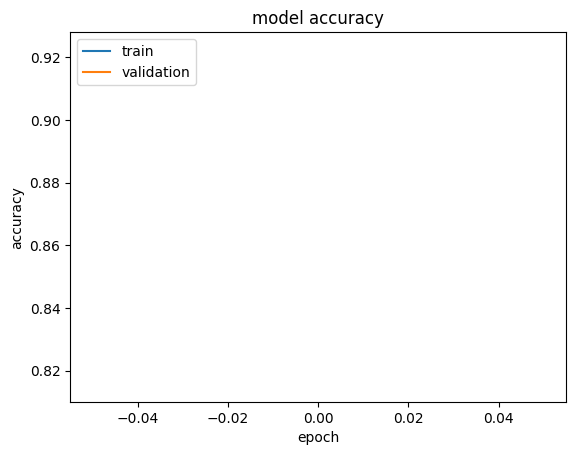

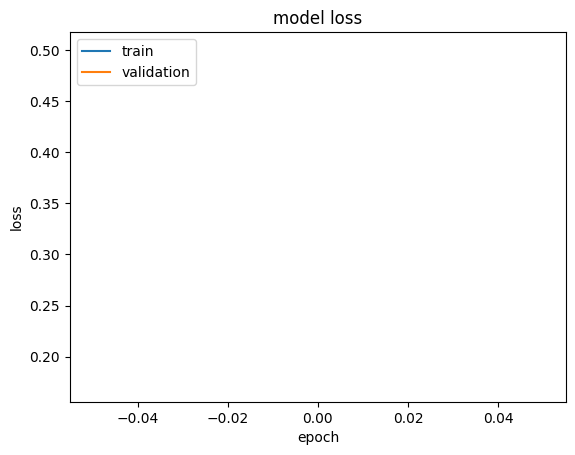

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

6. Evaluation

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/CNN_biLSTM_dataset2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
predictor = load_model('/content/drive/MyDrive/biLSTM_dataset2.h5')

In [ ]:
predictions = predictor.predict(X_test_pad)


2606/2606 [==============================] - 415s 159ms/step


In [ ]:
from sklearn.metrics import classification_report

# Assuming predictions and data_test.label contain the predicted and true labels respectively

# Print classification report
print(classification_report(data_test.label, predictions))

              precision    recall  f1-score   support

       anger       0.90      0.94      0.92     11339
        fear       0.90      0.88      0.89      9376
         joy       0.94      0.94      0.94     28247
        love       0.84      0.83      0.83      6853
     sadness       0.96      0.95      0.96     24504
    surprise       0.81      0.80      0.80      3043

    accuracy                           0.92     83362
   macro avg       0.89      0.89      0.89     83362
weighted avg       0.92      0.92      0.92     83362



In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.label, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.label, predictions, average='micro') * 100))

Accuracy: 92.26%

F1 Score: 92.26


In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 92.26


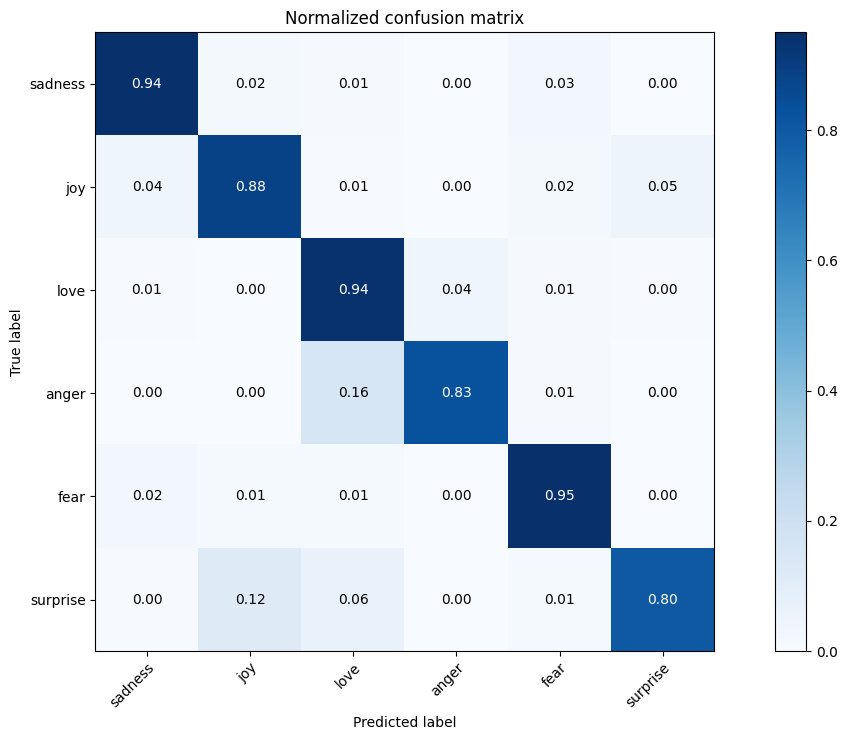

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.label, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.label, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Try other input

In [ ]:
import time

message = ['When I meet you first time it was wonderful']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 219ms/step
Message: ['When I meet you first time it was wonderful']
predicted: joy (0.50 seconds)
